<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [0]:
!pip install --pre --quiet astroquery

In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0-rc1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Get the data
First download the dataset.-

In [0]:
data = SDSS.query_sql("""SELECT TOP 1000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z,s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO' AND s.class !='GALAXY'
                      
                      """)

In [86]:
datapd=data.to_pandas()
print(datapd)

     fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0      19.78761    18.81021    18.55947    18.44454    18.41792        6500
1      20.46545    18.85142    18.35061    18.20708    18.03558        5320
2      21.66110    19.73356    18.55408    17.59462    17.06819        3717
3      22.62621    20.00452    18.71349    18.09788    17.74249        3962
4      20.43118    19.23725    18.69031    18.43371    18.32838        5324
5      22.78794    20.05930    18.60072    17.73286    17.27581        3980
6      19.08168    18.16120    17.80042    17.95433    17.62448        6000
7      20.29089    19.22616    19.01667    18.98399    18.98821        7000
8      19.33295    18.22913    18.02131    17.98577    17.99690        7500
9      17.26937    16.06997    15.61546    15.45759    15.42821        5860
10     18.52893    17.50824    17.06644    16.90901    16.87038        6000
11     19.61317    18.54408    18.13484    18.02099    18.00498        5873
12     22.48

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)


### Inspect the data

Look at the overall statistics:

In [88]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,800.0,20.106835,1.906204,15.83426,18.843650,19.748945,21.177308,26.24836
fiberMag_g,800.0,18.750429,1.721557,15.31662,17.606813,18.605115,19.545817,26.15056
fiberMag_r,800.0,18.186018,1.479188,14.92595,17.155590,18.128115,18.951463,23.55924
fiberMag_i,800.0,17.876560,1.328272,14.78577,16.938932,17.794600,18.760043,21.91380
fiberMag_z,800.0,17.714676,1.323644,14.66739,16.755370,17.660985,18.583395,21.89454


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [0]:
#norm train label
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [91]:

#normtest_temp=tf.keras.utils.normalize(test_labels,axis=0)
train_mean=train_labels.mean()
train_std=train_labels.std()


norm_train_labels=(train_labels-train_mean)/train_std
norm_train_feat = (train_feat - train_feat.mean())/train_feat.std()
print(norm_train_labels)

993   -0.825415
859   -1.331577
298   -0.128596
553   -0.134746
672    1.617450
971   -0.148891
27     1.002429
231    1.002429
306    0.387407
706    0.387407
496    0.079897
558    0.079897
784    0.079897
239   -1.217799
578    1.650661
55    -0.915208
906   -1.324197
175   -0.562801
14     1.924961
77    -0.915208
31    -1.324197
481    1.617450
310   -1.324197
311   -1.000081
883   -0.673505
788   -0.453942
45    -1.237479
103   -0.092309
760    1.002429
1     -0.338318
         ...   
216   -0.076319
735    0.079897
129   -1.237479
349    0.079897
111    0.079897
166   -0.498838
207    0.301919
438    0.079897
552    0.079897
274    0.079897
974   -0.399205
591   -1.326042
800   -0.049258
937   -0.405355
525   -1.150146
287    0.103267
469    0.079897
326    1.095912
121   -0.112605
994    1.002429
507   -0.562801
228    1.002429
673    0.079897
595    0.387407
445   -0.795894
117   -0.933044
464   -0.933044
25     1.002429
110   -0.795894
149   -1.173517
Name: elodieTEff, Length

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.



## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(6, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(1, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    #layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [93]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [94]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

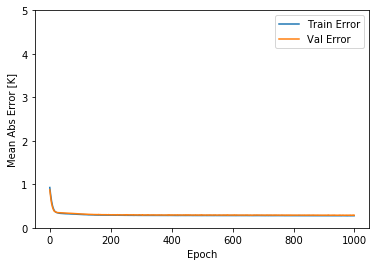

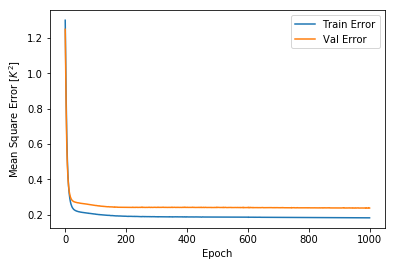

In [111]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [0]:
#model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(norm_train_feat, train_labels, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
#print(history)
#plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [97]:
norm_test_feat = (test_feat-test_feat.mean())/test_feat.std()
norm_test_labels = (test_labels-test_labels.mean())/test_labels.std()


loss, mae, mse = model.evaluate(norm_test_feat, norm_test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Kelvin".format(mae))

Testing set Mean Abs Error:  0.36 Kelvin


### Make predictions

Finally, predict Temperature values using data in the testing set:

(-1.6450949093300815, 3.14022587254141, -1.1151085468383286, 3.670212235033163)

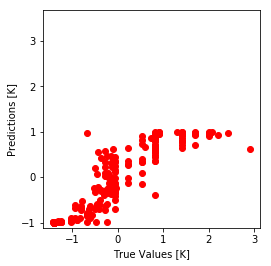

In [101]:
#print(norm_test_labels)

test_predictions = model.predict(norm_test_feat).flatten()
#print(test_predictions)

plt.scatter(norm_test_labels, test_predictions, color='red')
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

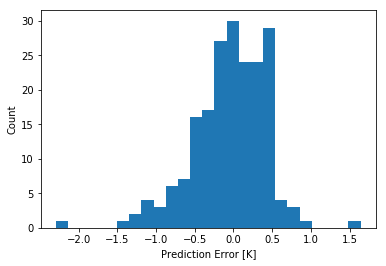

In [110]:
error = test_predictions - norm_test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.



## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.
